In [728]:
%matplotlib inline

(chap-waldanteil)=
# Aufgabe 15: Vereinigen aller Einzelteile

## Theorie

Um an diesen Punkt zu kommen habt ihr euch diverse Werkzeuge aneignen müssen (*Functions*, *For Loops*, *GIS*) und habt dazu Übungen gelöst. Die nachstehenden Code Blöcke nutzt Elemente aus diesen Übungen um auf den gleichen Stand zu kommen, mit der ihr im Themenblock "Datenqualität und Unsicherheiten" in die Übung gestartet seid. Ihr hattet damals (a) Simulierte Zeckenstich-Daten und (b) einen Layer Waldinformation im Projektgebiet. 

Kopiere die Code Blöcke in ein frisches Notebook und versuche den Code zu verstehen - sie sollten dir sehr bekannt vorkommen. Schau, ob du gewisse Teile an deine Umgebung anpassen musst.

---

Lade die benötigten Module (siehe {ref}`chap-modules-import`): 

In [729]:
# Benötigten Module laden #####################
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
###############################################

Definiere die benötigte *Function* (siehe {ref}`ex-offset-function`):

In [730]:
# Notwendige Functions definieren #############
def offset_coordinate(old, distance = 100):
    import random
    new = old + random.normalvariate(0,distance)
    return(new)
###############################################

Importiere die notwendigen Datensätze (siehe {ref}`ex-import-zeckenstiche` und {ref}`ex-import-wald`):

In [731]:
# Daten Importieren ###########################
zeckenstiche = pd.read_csv("zeckenstiche.csv")
wald = gpd.read_file("wald.gpkg")
###############################################

Simuliere die Zeckenstiche (siehe {ref}`ex-monte-carlo-loop`):

In [755]:
# Daten Simulieren ############################
monte_carlo = []
for i in range(5):
    zeckenstiche["x_sim"] = zeckenstiche["x"].apply(offset_coordinate)
    zeckenstiche["y_sim"] = zeckenstiche["y"].apply(offset_coordinate)
    zeckenstiche["Run"] = i
    monte_carlo.append(zeckenstiche.copy())
    
monte_carlo_df = pd.concat(monte_carlo)
###############################################

## Übungen

Wir wollen nun den Anteil der Zeckenstiche pro "Simulationsrunde", sprich pro *Loop* Iteration, ermitteln. Diese ist in `monte_carlo_df` mit `Run` gekennzeichnet. Dafür müssen wir noch folgendes machen:

1. Die *DataFrame* `monte_carlo_df` in eine *GeoDataFrame* konvertieren
2. Für jeden simulierten Punkt ob er sich im Wald befindet oder nicht
3. Der Anteil der Zeckenstiche im Wald *pro Run* ermitteln
4. Verteilung dieser berechneten Anteile visualisieren

(ex-14-1)=
### Übung 15.1 

Konvertiere `monte_carlo_df` in eine *GeoDataFrame* und speichere den Output als `monte_carlo_gpd`. Setze dabei auch das Korrekte Koordinatensystem. Schaue dir nochmal {ref}`chap-pythongis` an wenn du dir unsicher bist, wie das geht.

In [733]:
# Musterlösung

monte_carlo_gpd = gpd.GeoDataFrame(monte_carlo_df,
                                    geometry=gpd.points_from_xy(monte_carlo_df['x_sim'], monte_carlo_df['y_sim']),
                                    crs = 2056) 

(ex-14-3)=
### Übung 15.2

Ermittle für jeden simulierten Punkt, ob er im Wald ist oder nicht und speichere den Output als `monte_carlo_join`. Schaue dir nochmal {ref}`chap-spatialjoin` an wenn du dir unsicher bist, wie das geht. Schau dir anschliessend `monte_carlo_join` an. Sortiere die *GeoDataFrame nach "Run" (`monte_carlo_join.sort_values("Run")`) um anschliessend nach "ID" und versuche so, die Daten zu verstehen.

In [743]:
# Musterlösung

monte_carlo_join = gpd.sjoin(monte_carlo_gpd, wald)

```python
# Musterlösung

monte_carlo_join.sort_values("Run")
monte_carlo_join.sort_values("ID")
```

### Übung 15.3

Nun wollen wir von jeder Iteration (bzw. jedem "Run") wissen, wie viele der der Simulierten Punkte sich im Wald und wie viel sich ausserhalb des Waldes befinden. Dafür müssen wir `monte_carlo_join` nach "Run" und "Wald_text" gruppieren (mit `.groupby` und anschliessend die Anzahl der Werte berechnen (mit `.size`). Führe diese Schritte bei dir aus und schau dir den Output an.

In [735]:
# Hier manipuliere ich die Daten um es so aussehen zu lassen, als seien im 
# Run nummer 4 alle Zeckenstiche im Wald gelandet. Der Code ist für die 
# Studis nicht ersichtlich.
monte_carlo_join.loc[monte_carlo_join.Run == 4,"Wald_text"] = "ja"

0    ja
1    ja
2    ja
4    ja
6    ja
3    ja
5    ja
7    ja
8    ja
9    ja
Name: Wald_text, dtype: object

In [736]:
monte_carlo_join.groupby(["Run","Wald_text"]).size()

Run  Wald_text
0    ja            6
     nein          4
1    ja            1
     nein          9
2    ja            3
     nein          7
3    ja            5
     nein          5
4    ja           10
dtype: int64

### Übung 15.4

Das ist schon mal nahe dran an was wir wollen, wir haben nun aber für jede Iteration zwei Zeilen: Eine für "Ja" (im Wald) und eine für "Nein" (nicht im Wald). Für die kommenden Schritte wäre es aber praktischer, wenn wir pro Iteration eine Zeile hätten und in zwei Spalten die Anzahl ("Ja" und "Nein") die Anzahl Werte im Wald und ausserhalb des Waldes. Dies erreichen wir druch den Zusatz `.unstack()`. Führe diesen Befehl bei dir aus und schau dir den Output an.


In [737]:
monte_carlo_join.groupby(["Run","Wald_text"]).size().unstack()

Wald_text,ja,nein
Run,,
0,6.0,4.0
1,1.0,9.0
2,3.0,7.0
3,5.0,5.0
4,10.0,NaN


### Übung 15.5

In meiner Simulation sind im Run Nummer 4 alle Zeckenstiche im Wald gelandet, deshalb steht dort in der Spalte "Nein" der Wert `NaN` ("*not a number*"). Mit `fill_value` kann festgeleget werden, was in einem solchen Fall passieren soll. In unserem Fall ist ein `fill_value` von `0` sinnvoll. Ergänze dies in deinem Code und speichere den Output als `mont_carlo_results`.

In [739]:
mont_carlo_results = monte_carlo_join.groupby(["Run","Wald_text"]).size().unstack(fill_value = 0)

mont_carlo_results

Wald_text,ja,nein
Run,,
0,6,4
1,1,9
2,3,7
3,5,5
4,10,0


### Übung 15.6

Wir haben nun die *Anzahl* der Werte pro Kategorie und Interation, aussagekräftiger wäre aber deren *Anteil* `ja_anteil = ja / (ja+nein)`. Erstelle eine neue Spalte "ja_anteil" wo der Anteil der Punkte im Wald enthalten ist.

In [745]:
# Musterlösung

mont_carlo_results = mont_carlo_results.assign(ja_anteil = lambda x: x.ja/(x.ja+x.nein))

In [746]:
# Das Resultat sollte folgendermassen aussehen:
mont_carlo_results

Wald_text,ja,nein,ja_anteil
Run,,,
0,6,4,0.6
1,1,9,0.1
2,3,7,0.3
3,5,5,0.5
4,10,0,1.0


%: Mittelwerte Visualisieren
### Übung 15.7

Gratuliere! Wenn du an diesem Punkt angekommen bist hast du eine ganze Monte Carlo Simulation von A bis Z mit Python durchgeführt. Von hier an steht dir der Weg frei für noch komplexere Analysen. Zum Abschluss kannst du die Mittelwerte wir nun auf einfache Weise visualisieren. Versuche dabei die Methods `plot()` und `boxplot()`.

<AxesSubplot:xlabel='Run'>

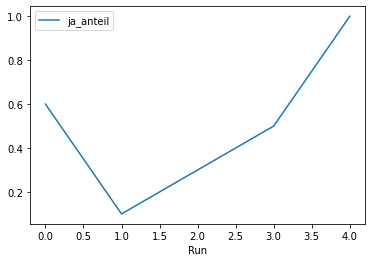

In [799]:
# Musterlösung

mont_carlo_results.plot(y = "ja_anteil")

<AxesSubplot:>

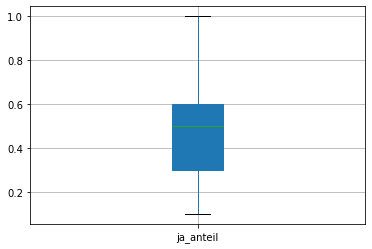

In [803]:
# Musterlösung

mont_carlo_results.boxplot("ja_anteil", patch_artist=True)